# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

### Initialization ###
Starting Spark session:

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

: 

In [2]:
spark

In [3]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [4]:
import urllib.request

In [5]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7f1f142b9c70>)

Create a first RDD

In [6]:
lines = sc.textFile("apache_logs")

Perform a *transformation*

In [7]:
lineLengths = lines.map(lambda s: len(s))

Perform an *action*

In [8]:
totalLength = lineLengths.reduce(lambda a, b: a + b)

Finally evaluate (laziness!)

In [9]:
totalLength

2360789

### Custom functions

In [10]:
def myFunc(s):
    words = s.split(" ")
    return len(words)

In [11]:
wordCounts = lines.map(myFunc)

In [12]:
wordCounts.max()

43

In [13]:
wordCounts.histogram([0,10,20,30,40,50])

([0, 10, 20, 30, 40, 50], [0, 4901, 4719, 378, 2])

In [14]:
wordCounts.count()

10000

### Map-Reduce pattern

Let's look closer at our log file format:

```
99.158.0.150 - - [18/May/2015:04:05:37 +0000] "GET /images/jordan-80.png HTTP/1.1" 200 6146 "http://www.semicomplete.com/articles/dynamic-dns-with-dhcp/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/32.0.1700.102 Chrome/32.0.1700.102 Safari/537.36"
```

Count lines containing "Chrome":

In [15]:
chromeLines = lines.map(lambda s: (1 if "Chrome" in s else 0))

In [16]:
counts = chromeLines.reduce(lambda a, b: a + b)

In [17]:
counts

3172

### Key-Value Pairs

Count IP addresses

In [18]:
regex = '([(\d\.)]+)'

In [19]:
import re

In [20]:
ip = re.match(regex, '99.158.0.150 - - ').group(0)

In [21]:
print(ip)

99.158.0.150


In [22]:
ips = lines.map(lambda s: (re.match(regex, s).group(0) ,1))

In [23]:
ipCounts = ips.reduceByKey(lambda a, b: a + b)

Get results

In [24]:
ipCounts.collect()

[('83.149.9.216', 23),
 ('110.136.166.128', 6),
 ('46.105.14.53', 364),
 ('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('67.214.178.190', 2),
 ('207.241.237.220', 18),
 ('207.241.237.227', 17),
 ('207.241.237.228', 16),
 ('218.30.103.62', 16),
 ('71.212.224.97', 5),
 ('86.1.76.62', 6),
 ('107.170.41.69', 10),
 ('208.115.111.72', 83),
 ('174.37.205.76', 1),
 ('134.76.249.10', 8),
 ('123.125.71.117', 1),
 ('65.19.138.34', 3),
 ('5.102.173.71', 2),
 ('187.45.193.158', 8),
 ('36.38.8.174', 6),
 ('71.207.12.53', 2),
 ('220.241.45.142', 2),
 ('146.1.1.2', 15),
 ('178.255.215.83', 22),
 ('50.131.51.216', 17),
 ('212.197.170.45', 2),
 ('108.32.74.68', 14),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('108.178.4.100', 2),
 ('111.199.235.239', 37),
 ('108.171.116.194', 65),
 ('94.175.135.116', 1),
 ('207.241.237.104', 13),
 ('83.31.73.148', 2),
 ('180.76.6.156', 2),
 ('92.108.120.46', 2),
 ('172.56.29.98', 1),
 ('173.252.73.114', 1),
 ('217.69.133.70', 4),
 ('217.69.133.237', 4),
 ('209.17.114

In [25]:
ipCounts.take(20)

[('83.149.9.216', 23),
 ('110.136.166.128', 6),
 ('46.105.14.53', 364),
 ('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('67.214.178.190', 2),
 ('207.241.237.220', 18),
 ('207.241.237.227', 17),
 ('207.241.237.228', 16),
 ('218.30.103.62', 16),
 ('71.212.224.97', 5),
 ('86.1.76.62', 6),
 ('107.170.41.69', 10),
 ('208.115.111.72', 83),
 ('174.37.205.76', 1),
 ('134.76.249.10', 8),
 ('123.125.71.117', 1),
 ('65.19.138.34', 3),
 ('5.102.173.71', 2),
 ('187.45.193.158', 8)]

Sort by values (ascending):

In [26]:
ipCounts.takeOrdered(10, lambda pair: pair[1])

[('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('174.37.205.76', 1),
 ('123.125.71.117', 1),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('94.175.135.116', 1),
 ('172.56.29.98', 1),
 ('173.252.73.114', 1),
 ('54.226.176.99', 1)]

Sort by values (descending):

In [27]:
topIPs = ipCounts.takeOrdered(10, lambda pair: -pair[1])
topIPs

[('66.249.73.135', 482),
 ('46.105.14.53', 364),
 ('130.237.218.86', 357),
 ('75.97.9.59', 273),
 ('50.16.19.13', 113),
 ('209.85.238.199', 102),
 ('68.180.224.225', 99),
 ('100.43.83.137', 84),
 ('208.115.111.72', 83),
 ('198.46.149.143', 82)]

### Plotting

In [28]:
import pandas as pd

In [29]:
df = pd.DataFrame(topIPs, columns=['IP', 'Count'])
df

,IP,Count
0,66.249.73.135,482
1,46.105.14.53,364
2,130.237.218.86,357
3,75.97.9.59,273
4,50.16.19.13,113
5,209.85.238.199,102
6,68.180.224.225,99
7,100.43.83.137,84
8,208.115.111.72,83
9,198.46.149.143,82


In [30]:
import matplotlib.pyplot as plt

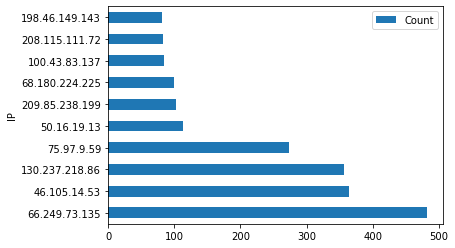

In [31]:
df.plot.barh(x = 'IP')

### Closures and accumulators

Local variables are not passed to closures or functions, they remain local!

In [32]:
counter = 0

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x

wordCounts.foreach(increment_counter)

print("Counter value: ", counter)

Counter value:  0


Use *accumulators* instead

In [33]:
accum = sc.accumulator(0)
accum

Accumulator<id=0, value=0>

In [34]:
# Correct way is to use accumulators
def increment_counter(x):
    accum.add(x)

wordCounts.foreach(increment_counter)

print("Counter value: ", accum)

Counter value:  197956
